# Cross-slope section

This notebook gives an example on how to obtain a section through gridded data. We use the __[function](https://unidata.github.io/MetPy/latest/examples/cross_section.html#sphx-glr-examples-cross-section-py)__ `metpy.interpolate.cross_section` to do so. 
In this example we plot the along-slope velocity component across the Antarctic continental shelf break. In order to calculate the along-slope velocity component, we will need to calculate the topographic gradient first, which we do with the help of the `xgcm` __[module](https://xgcm.readthedocs.io/en/latest/)__. 

Load modules

In [1]:
# Standard modules
import cosima_cookbook as cc
from dask.distributed import Client
import numpy as np
import xarray as xr

# For gradient calculation 
# (We will need the topographic gradient to calculate the along-slope velocity component)
import xgcm

# Load metpy module to obtain cross section 
# (Select the conda/analusis3-unstable kernel if you have problems loading this module)
from metpy.interpolate import cross_section

# For plotting
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import matplotlib.path as mpath
import cmocean as cm

Start a cluster with multiple cores

In [2]:
client = Client() 
client

distributed.diskutils - INFO - Found stale lock file and directory '/jobfs/32853469.gadi-pbs/dask-worker-space/worker-stvqwhtx', purging
distributed.diskutils - INFO - Found stale lock file and directory '/jobfs/32853469.gadi-pbs/dask-worker-space/worker-pc35s25f', purging


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/44531/status,
Dashboard: /proxy/44531/status,Workers: 4
Total threads: 12,Total memory: 48.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:34309,Workers: 4
Dashboard: /proxy/44531/status,Total threads: 12
Started: Just now,Total memory: 48.00 GiB
Comm: tcp://127.0.0.1:35245,Total threads: 3
Dashboard: /proxy/40357/status,Memory: 12.00 GiB
Nanny: tcp://127.0.0.1:45887,


Nominate a database from which to load the data and define an experiment

In [3]:
# Load database
session = cc.database.create_session()
# Define experiment in database
expt = '01deg_jra55v13_ryf9091'

Load velocity and bathymetry data

In [4]:
# Select data in the southern Southern Ocean
lat_slice  = slice(-80, -59)

# We will use an annual average from one year in the RYF run
start_time = '2086-01-01'
end_time   = '2086-12-31'

# Import bathymetry
hu = cc.querying.getvar(expt, 'hu', session, n=1)
hu = hu.sel(yu_ocean=lat_slice)
hu = hu.load()

# Import velocity data (upper 500 m)
u = cc.querying.getvar(expt, 'u', session, start_time=start_time, end_time=end_time, ncfile="ocean.nc")
u = u.sel(time=slice(start_time, end_time)).mean('time')
u = u.sel(yu_ocean=lat_slice).sel(st_ocean=slice(0, 500))

v = cc.querying.getvar(expt, 'v', session, start_time=start_time, end_time=end_time, ncfile="ocean.nc")
v = v.sel(time=slice(start_time, end_time)).mean('time')
v = v.sel(yu_ocean=lat_slice).sel(st_ocean=slice(0, 500))

### Along-slope velocity

We calculate the along-slope velocity component by projecting the velocity field to the tangent vector, $u_{along} = \boldsymbol{u \cdot \hat{t}$, and the cross-slope component by projecting to the normal vector, $v_{cross} = \boldsymbol{u \cdot \hat{n}}$. The schematic below defines the unit normal normal and tangent vectors for a given bathymetric contour, $\boldsymbol{n}$ and $\boldsymbol{t}$ respectively. 

![Sketch of topographic gradient](images/topographic_gradient_sketch.png)

Accordingly, the code below calculates the along-slope velocity component as

$$ u_{along} = (u,v) \boldsymbol{\cdot} \left(\frac{h_y}{|\nabla h|} , -\frac{h_x}{|\nabla h|}\right) = 
u \frac{h_y}{|\nabla h|} - v \frac{h_x}{|\nabla h|}, $$  

and similarly the cross-slope velocity component as

$$ v_{cross} = (u,v) \boldsymbol{\cdot} \left(\frac{h_x}{|\nabla h|} , \frac{h_y}{|\nabla h|}\right)  = 
u \frac{h_x}{|\nabla h|} + v \frac{h_y}{|\nabla h|}.$$ 


We need the derivatives of the bathymetry which we compute using the `xgcm` functionality.

In [5]:
# Load model grid information
path_to_folder = '/g/data/ik11/outputs/access-om2-01/01deg_jra55v13_ryf9091/output000/ocean/'
grid = xr.open_mfdataset(path_to_folder + 'ocean_grid.nc', combine='by_coords')

# Give information on the grid: location of u (momentum) and t (tracer) points on B-grid 
ds = xr.merge([hu, grid])
ds.coords['xt_ocean'].attrs.update(axis='X')
ds.coords['xu_ocean'].attrs.update(axis='X', c_grid_axis_shift=0.5)
ds.coords['yt_ocean'].attrs.update(axis='Y')
ds.coords['yu_ocean'].attrs.update(axis='Y', c_grid_axis_shift=0.5)

grid = xgcm.Grid(ds, periodic=['X'])

# Take topographic gradient (simple gradient over one grid cell) and move back to u-grid
dhu_dx = grid.interp( grid.diff(ds.hu, 'X') / grid.interp(ds.dxu, 'X'), 'X')

# In meridional direction, we need to specify what happens at the boundary
dhu_dy = grid.interp( grid.diff(ds.hu, 'Y', boundary='extend') / grid.interp(ds.dyt, 'X'), 'Y', boundary='extend')

# Select latitude slice
dhu_dx = dhu_dx.sel(yu_ocean=lat_slice)
dhu_dy = dhu_dy.sel(yu_ocean=lat_slice)

# Magnitude of the topographic slope (to normalise the topographic gradient)
topographic_slope_magnitude = np.sqrt(dhu_dx**2 + dhu_dy**2)

Calculate along-slope velocity component

In [6]:
# Along-slope velocity
u_along = u * dhu_dy / topographic_slope_magnitude - v * dhu_dx / topographic_slope_magnitude

# Load the data
u_along = u_along.load()

# Similarly, we can calculate the cross-slope velocity:
#v_cross = u*dhu_dx/topographic_slope_magnitude + v*dhu_dy/topographic_slope_magnitude

/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.10/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.10/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.10/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.10/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


Vertical averaging (we only need this to plot the velocity on a map)

In [7]:
# Import edges of st_ocean and add lat/lon dimensions:
st_edges_ocean = cc.querying.getvar(expt, 'st_edges_ocean', session, start_time=start_time, end_time=end_time, n=1)
st_edges_array = st_edges_ocean.expand_dims({'yu_ocean': u.yu_ocean, 'xu_ocean': u.xu_ocean}, axis=[1, 2])

# Adjust edges at bottom for partial thickness:
st_edges_with_partial = st_edges_array.where(st_edges_array<hu, other=hu)
thickness = st_edges_with_partial.diff(dim='st_edges_ocean')

# Change coordinate of thickness to st_ocean (needed for multipling with other variables):
st_ocean = cc.querying.getvar(expt, 'st_ocean', session, n=1)
thickness['st_edges_ocean'] = st_ocean.values
thickness = thickness.rename(({'st_edges_ocean': 'st_ocean'}))
thickness = thickness.sel(st_ocean=slice(0, 500))

# Depth average gives us the barotropic velocity
u_barotropic = (u_along * thickness).sum('st_ocean') / thickness.sum('st_ocean')
#v_barotropic = (v_cross * thickness).sum('st_ocean') / thickness.sum('st_ocean')

### Interpolate gridded data to section

This is where we make use of the `cross-section` function from the MetPy package. It is designed for xarray, but requires the data to look in a certain way, hence we need to change the coordinate names and parse the data. 

In [8]:
# Create dataset
ds = xr.Dataset({"u_along": u, "lat": u.yu_ocean, "lon": u.xu_ocean, "hu": hu})

# Rename coordinate names
ds = ds.rename({'xu_ocean': 'x', 'yu_ocean': 'y'})

# Convert latitude from ACCESS-OM2 default range of [-280, 80] to [-180, 180] since this is what metpy expects.
ds['x'] = ds['x'] + 100
ds['x'].attrs = u['xu_ocean'].attrs

# MetPy parsing
u_parsed = ds.metpy.parse_cf('u_along', coordinates={'y': 'y', 'x': 'x'})

Found valid latitude/longitude coordinates, assuming latitude_longitude for projection grid_mapping variable


In [9]:
# Define number of points you want to interpolate
step_no = 50

# Start and end point coordinates of section (in approximate cross-slope orientation)
shelf_coord = (-66.5, -269.3 + 100)
deep_coord  = (-64, -271.9 + 100)

# Finally, interpolate gridded data onto the section
u_section = cross_section(u_parsed, start=(shelf_coord[0], shelf_coord[1]), end=(deep_coord[0], deep_coord[1]), steps=step_no, interp_type='linear')
u_section

<xarray.DataArray 'u_along' (st_ocean: 39, index: 50)>
dask.array<dask_aware_interpnd, shape=(39, 50), dtype=float32, chunksize=(7, 50), chunktype=numpy.ndarray>
Coordinates:
  * st_ocean   (st_ocean) float64 0.5413 1.681 2.94 4.332 ... 383.0 423.7 468.4
    geolon_c   (index) float64 -269.3 -269.4 -269.4 ... -271.8 -271.9 -271.9
    geolat_c   (index) float64 -66.5 -66.45 -66.4 -66.35 ... -64.1 -64.05 -64.0
    metpy_crs  object Projection: latitude_longitude
    x          (index) float64 -169.3 -169.4 -169.4 ... -171.8 -171.9 -171.9
    y          (index) float64 -66.5 -66.45 -66.4 -66.35 ... -64.1 -64.05 -64.0
  * index      (index) int64 0 1 2 3 4 5 6 7 8 9 ... 41 42 43 44 45 46 47 48 49

Finally calculate the distance along the transect (for plotting purposes)

In [11]:
# Radius of the Earth in km
r = 6371

# Difference between points in lat/lon space
dlon = deep_coord[1] - shelf_coord[1]
dlat = deep_coord[0] - shelf_coord[0]

# Calculate distance in km between the two end points
distance_endpoints = r * np.deg2rad(np.sqrt(dlat**2 + (dlon*np.cos(np.deg2rad(np.mean([shelf_coord[0], deep_coord[0]]))))**2))

# Create array with length of step_no
distance_in_km = np.linspace(0, distance_endpoints, step_no)

# Repeat by the number of depth levels
distance_in_km = np.tile(distance_in_km, (len(u_section.st_ocean), 1))

### Plotting

In [16]:
# For polar projection
theta  = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.45
verts  = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

# Data required for lat/lon mapping
land_mask = 0 * np.squeeze(hu.values)
land_mask[np.isnan(land_mask)] = 1
land_mask = np.ma.masked_where((land_mask==0),land_mask)

# Make land go all the way to -90S:
land_mask_lat = hu.yu_ocean.values
land_mask_lat[0] = -90

# create a land data array
land = hu.copy().rename('land')
land.data = land_mask

# Fontsize
ft_size = 16;

Map of topographic slope and location of cross-slope section

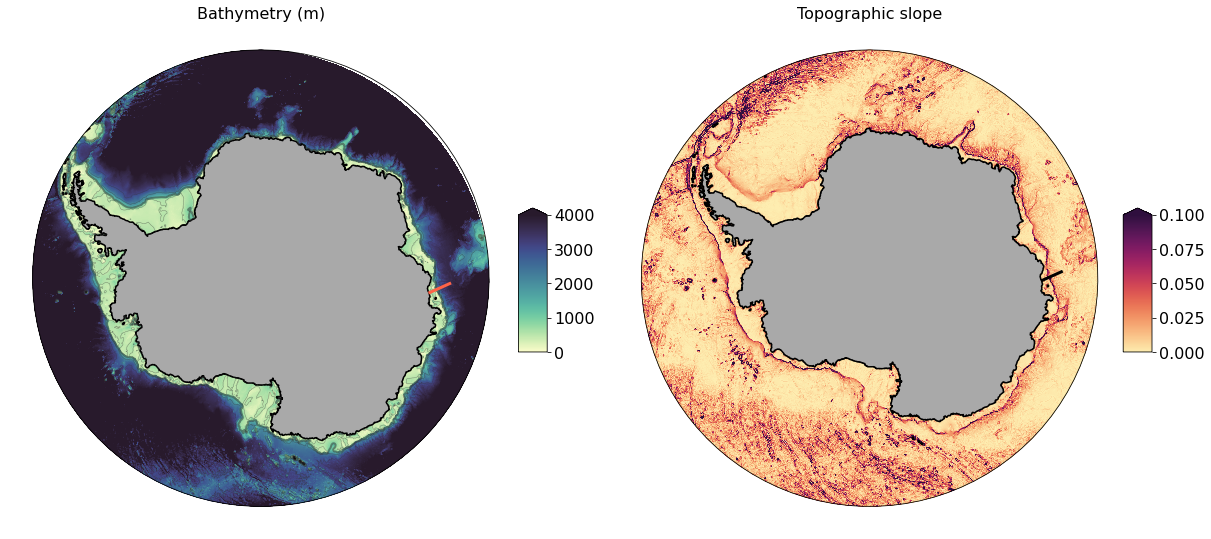

In [17]:
fig = plt.figure(1, figsize=(20, 10))

# create suplot axes
ax0 = plt.subplot(1, 2, 1, projection=ccrs.SouthPolarStereo())
ax1 = plt.subplot(1, 2, 2, projection=ccrs.SouthPolarStereo())

for ax in [ax0, ax1]:
    ax.set_boundary(circle, transform=ax.transAxes)

    # Plot land
    land.plot.contourf(ax=ax, colors='darkgrey', zorder=2, transform=ccrs.PlateCarree(), add_colorbar=False)

    # Plot coastline
    land.fillna(0).plot.contour(ax=ax, colors='k', levels=[0, 1], transform=ccrs.PlateCarree(), add_colorbar=False)


# LEFT PANEL: bathymetry

hu.plot.contour(ax=ax0, levels=[500, 1000, 2000, 3000],
            colors='0.2', linewidths=[0.5, 2, 0.5, 0.5], alpha=0.5, transform=ccrs.PlateCarree())

sc = hu.plot(ax=ax0, add_colorbar=False, cmap=cm.cm.deep, transform=ccrs.PlateCarree(), vmin=0, vmax=4000)

# Plot location of cross-slope section (East Antarctica)
ax0.plot([-269.3, -271.9], [-66.5, -64], color='tomato', linewidth=3, transform=ccrs.PlateCarree())

# Colorbar
cbar_ax = fig.add_axes([0.48, 0.4, 0.02, 0.2])
cbar = plt.colorbar(sc, cax=cbar_ax, orientation='vertical', shrink=0.5, extend='max')
cbar.ax.tick_params(labelsize=ft_size)


# RIGHT PANEL: topographic slope

# Plot topographic slope 
sc = topographic_slope_magnitude.plot(ax=ax1, cmap=cm.cm.matter, transform=ccrs.PlateCarree(), vmin=0, vmax=0.1, add_colorbar=False)

# Plot location of cross-slope section (East Antarctica)
ax1.plot([-269.3, -271.9], [-66.5, -64], color='k', linewidth=3, transform=ccrs.PlateCarree())

# Colorbar
cbar_ax = fig.add_axes([0.9, 0.4, 0.02, 0.2])
cbar = plt.colorbar(sc, cax=cbar_ax, orientation='vertical', shrink=0.5, extend='max')
cbar.ax.tick_params(labelsize=ft_size)

# Add titles to the subplots
ax0.set_title('Bathymetry (m)', fontsize=ft_size)
ax1.set_title('Topographic slope', fontsize=ft_size);

Map of along-slope velocity with bathymetry contours

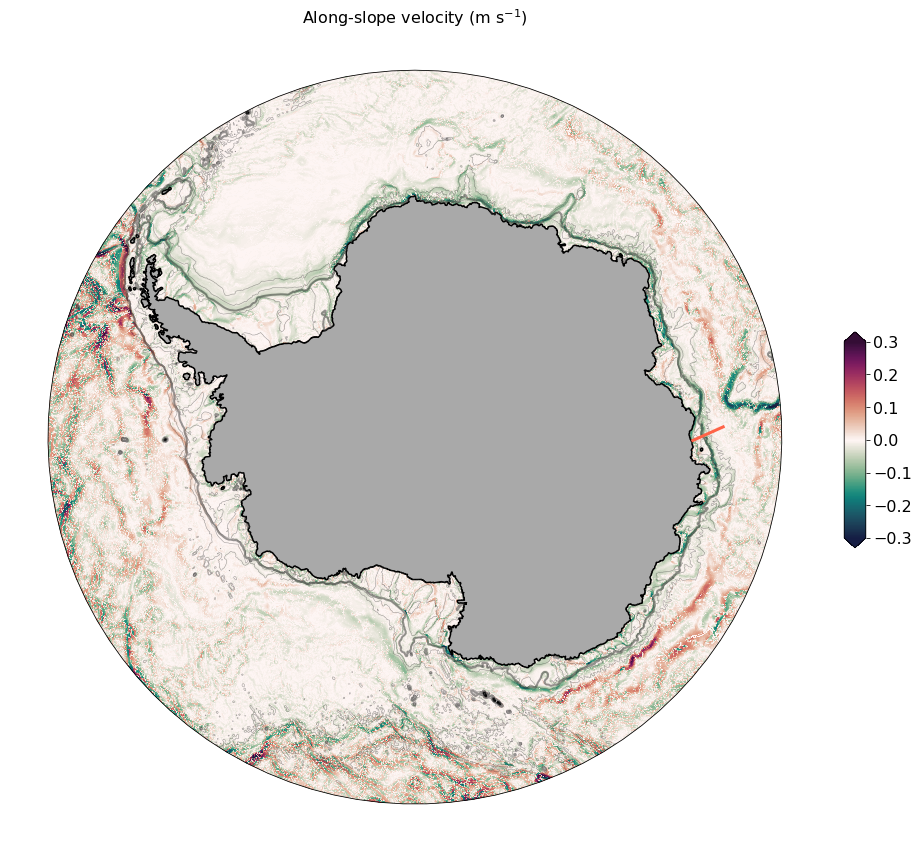

In [18]:
fig = plt.figure(1, figsize=(15,15))

ax = plt.subplot(1, 1, 1, projection=ccrs.SouthPolarStereo())

ax.set_boundary(circle, transform=ax.transAxes)
    
# Plot land
land.plot.contourf(ax=ax, colors='darkgrey', zorder=2, transform=ccrs.PlateCarree(), add_colorbar=False)

# Plot coastline
land.fillna(0).plot.contour(ax=ax, colors='k', levels=[0, 1], transform=ccrs.PlateCarree(), add_colorbar=False)

hu.plot.contour(ax=ax, levels=[500, 1000, 2000, 3000],
                colors='0.2', linewidths=[0.5, 2, 0.5, 0.5], alpha=0.5, transform=ccrs.PlateCarree())

sc = u_barotropic.plot(ax = ax, cmap=cm.cm.curl, transform=ccrs.PlateCarree(), vmin=-0.3, vmax=0.3, add_colorbar=False)

# Plot location of cross-slope section (East Antarctica)
ax.plot([-269.3, -271.9], [-66.5, -64], color='tomato', linewidth=3, transform=ccrs.PlateCarree())
    
ax.set_title('Along-slope velocity (m s$^{-1}$)', fontsize=ft_size)

# Colorbar
cbar_ax = fig.add_axes([0.91, 0.4, 0.02, 0.2])
cbar = plt.colorbar(sc, cax=cbar_ax, orientation='vertical', shrink=0.5, extend='both')
cbar.ax.tick_params(labelsize=ft_size);

Cross-slope section of along-slope velocity

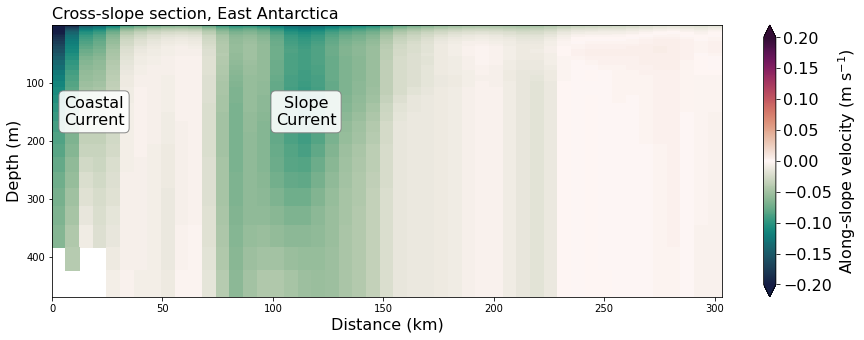

In [20]:
fig = plt.figure(figsize=(15, 5))

plt.title('Cross-slope section, East Antarctica', fontsize=ft_size, loc='left')

plt.pcolormesh(distance_in_km, u_section.st_ocean, u_section, cmap=cm.cm.curl, vmin=-0.2, vmax=0.2)

# Colorbar
cbar = plt.colorbar(extend='both')
cbar.set_label('Along-slope velocity (m s$^{-1}$)', fontsize=ft_size)
cbar.ax.tick_params(labelsize=ft_size)

# Axes
plt.gca().invert_yaxis()
plt.xlabel('Distance (km)', fontsize=ft_size)
plt.ylabel('Depth (m)', fontsize=ft_size)

# Add annotation
bbox_props = dict(boxstyle="round", fc="w", ec="0.5", alpha=0.9)

plt.text(115, 150, "Slope\nCurrent", ha="center", va="center", size=ft_size, bbox=bbox_props)
plt.text(19, 150, "Coastal\nCurrent", ha="center", va="center", size=ft_size, bbox=bbox_props);